In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
sns.set_style("whitegrid")

In [2]:
%matplotlib inline

# Data in all directions

If our exposure to Linear Regression has taught us one thing it's that if our data appears to follow a linear trend (ascending or descending in a straight line) we can find an optimal linear function $y = mx + b$ to fit to our data.  Unfortunately data is not always so friendly.

### Example:

Let's say our X axis represents a discrete distribution of age groups 12-99 and our Y axis represents average minutes spent sleeping per day.  Our intuition tells us that this is not a uniform or linear distribution. Depending on the samples it could take on any shape. Perhaps age groups that aren't heavily in the workforce yet show more minutes per day sleeping?  That would say ages 12-18 & 65+ would have higher Y values than the ages in between - giving us the shape of a U.

In [3]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


### Preparing the data

As usual we need to prepare our data.  Since our minutes are unweighted minutes we need to adjust them based on the respondents weight.

In [4]:
sleep_data = summary[['TUFINLWGT', 'TEAGE', 'TESEX', 't010101']]
sleep_data = sleep_data.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", "TESEX": "sex", "t010101": "minutes"})
sleep_data['weighted_minutes'] = sleep_data.weight * sleep_data.minutes
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Data columns (total 5 columns):
weight              11385 non-null float64
age                 11385 non-null int64
sex                 11385 non-null int64
minutes             11385 non-null int64
weighted_minutes    11385 non-null float64
dtypes: float64(2), int64(3)
memory usage: 533.7 KB


We can get our information grouped by calling the `groupby` function on the dataframe. The groupby does not return a dataframe by itself so we need to call a function on the groupby object in order to get a new dataframe.  In our case lets add all of the grouped columns with the `sum` function.

In [5]:
sleep_by_age = sleep_data.groupby("age").sum()
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes
age,,,,
15,1.168895e+09,159,62992,6.645155e+11
16,1.807565e+09,243,96196,1.013404e+12
17,1.929189e+09,246,96861,1.094304e+12
18,1.419704e+09,165,64722,8.498931e+11
19,1.307960e+09,130,50557,7.508169e+11


With all of our weighted minutes we can get the mean amount of minutes per age group by dividing the weight column by the weighted minutes column.

If this is not immediately clear why this works - it's because we added up every column - including the weight column.  So dividing the weighted minutes by the weight will give us the average weighted minutes per age group.

In [6]:
sleep_by_age['mean_minutes'] = sleep_by_age.weighted_minutes / sleep_by_age.weight
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes,mean_minutes
age,,,,,
15,1.168895e+09,159,62992,6.645155e+11,568.498993
16,1.807565e+09,243,96196,1.013404e+12,560.646005
17,1.929189e+09,246,96861,1.094304e+12,567.235373
18,1.419704e+09,165,64722,8.498931e+11,598.641088
19,1.307960e+09,130,50557,7.508169e+11,574.036484


Since we know these are minutes we can easily convert to hours by dividing by how many minutes there are in an hour. (60)  The cell below shows us how many hours on average a 38 year old gets per night.

In [7]:
sleep_by_age.loc[38].mean_minutes / 60

8.5302245832886427

We can visualize this on a scatter plot with the help of matplotlib. We want our X axis to represent age groups and our Y axis to represent minutes.

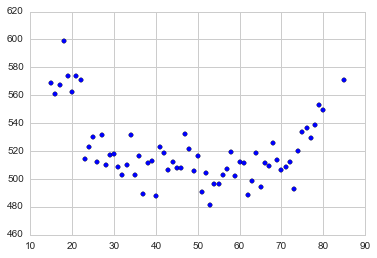

In [8]:
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)

### Linear Regression w/ Scikit-learn

We need to take one more step in data preparation to create a useful regression model.  Our sleep values need to be restructured. Why? Because if we pull the series from the dataframe and ask for the values we will be given a vector of numbers as:
$$
\begin{align}
\begin{bmatrix}1 & 2 & 3 & 4 & 5\end{bmatrix} \\
\end{align}
$$

Where we want them as a `n x 1` dimension matrix as:
$$
\begin{align}
\begin{bmatrix}1 \\ 2 \\ 3 \\ 4 \\ 5\end{bmatrix} \\
\end{align}
$$

We can do this by calling `.reshape((-1, 1))` on our values from the index.

In [9]:
regression = linear_model.LinearRegression()
reshaped_sleep_values = sleep_by_age.index.values.reshape((-1, 1))
regression.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Y-Intercept and Slope

We can even get the Y-Intercept and the slope of our fit regression model.

In [10]:
print("Slope: ", regression.coef_)
print("Y-Intercept: ", regression.intercept_)

Slope:  [-0.3727603]
Y-Intercept:  538.764180347


Before we go any further i'm going to make my life easier by creating a function that will display a scatter plot of my data while overlaying a linear function (our prediction line).

In [11]:
def plot_regression(fn):
    # scatter plot first
    plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
    xmin, xmax = plt.xlim()
    xs = np.linspace(xmin, xmax, 100)
    # fn is our (y = mx + b) expression
    plt.ylim(ymax=620, ymin=460)
    plt.plot(xs, [fn(x) for x in xs])

Thanks to Scikit-learn we have very little trial and error in finding minimum slope and y-intercept. It's already figured it out for us.

So let's create a function to return a predicted `Y` value for a given `X` value. Or in plain english - "For a given age, let's predict an amount of sleep they probably had"

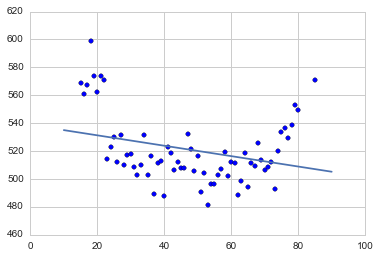

In [12]:
fn = lambda x: regression.predict(x)[0]
plot_regression(fn)

# Multiple Steps Made Easy w/ Pipeline

If you need to perform multiple operations on your model during the fit process - for example, giving it the instructions to fit the Regression model with Polynomial features to an nth degree, you can create a data processing pipeline and describe each of the steps by passing the function and name of the step as a tuple in a list.

It sounds confusing but it's really just taking a multi step operation and allowing you to perform it in one step.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

[ 0.]
520.84943152
Variance Score: 0.00


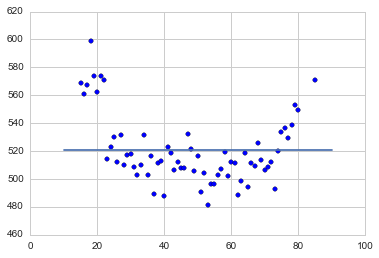

In [23]:
model = Pipeline([('poly', PolynomialFeatures(degree=0)),
                  ('linear', LinearRegression())])
LinearRegression
model.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
print(model.named_steps['linear'].intercept_)
print('Variance Score: %.2f' % model.score(reshaped_sleep_values, sleep_by_age.mean_minutes.values))

fn = lambda x: model.predict(x)[0]
plot_regression(fn)

Predicting a value on this model which has been fit to the 0th degree means that it will give the same value for any input. Not ideal!  Although I guess it does provide a mean of all age groups. /shrug

In [15]:
print(model.predict(32) / 60)
print(model.predict(50) / 60)

[ 8.68082386]
[ 8.68082386]


[ 0.        -0.3727603]
538.764180347
Variance Score: 0.09


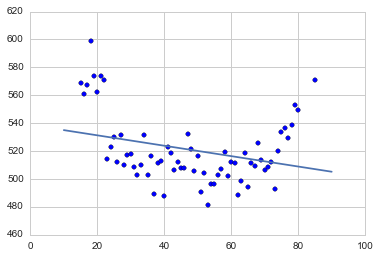

In [24]:
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression())])
model.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
print(model.named_steps['linear'].intercept_)
print('Variance Score: %.2f' % model.score(reshaped_sleep_values, sleep_by_age.mean_minutes.values))

fn = lambda x: model.predict(x)[0]

plot_regression(fn)

Predictions are still not great but they are at least trending downward. We can see that with our negative slope.  This matches our intuition... kind of.

In [25]:
print(model.predict(32) / 60)
print(model.predict(50) / 60)

[ 8.78059751]
[ 8.66876942]


Let's alter our pipeline to include more degrees of direction.  If we give it a 2nd degree our regression line becomes parabolic!

[ 0.         -5.66518847  0.05483183]
645.73364665
Variance Score: 0.68


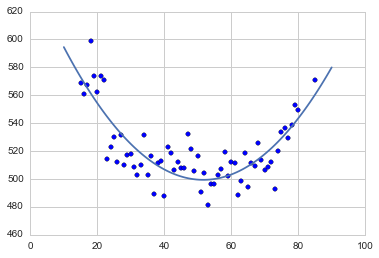

In [26]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])
model.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
print(model.named_steps['linear'].intercept_)
print('Variance Score: %.2f' % model.score(reshaped_sleep_values, sleep_by_age.mean_minutes.values))

fn = lambda x: model.predict(x)[0]
plot_regression(fn)

### Bonus question

What happened to our Y-Intercept?

------
If we increase the degree a few notches you can see the curved regression line attempts to get a little tighter on the scatter points. It may appear that we are getting a better fit to our data.

[  0.00000000e+00  -1.96775534e+01   4.95578215e-01  -4.70230260e-03
  -1.15898708e-06   1.87993805e-07]
Variance Score: 0.73


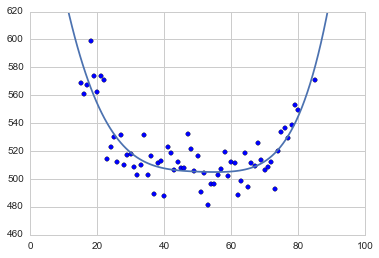

In [27]:
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                  ('linear', LinearRegression())])
model.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
print('Variance Score: %.2f' % model.score(reshaped_sleep_values, sleep_by_age.mean_minutes.values))
fn = lambda x: model.predict(x)[0]

plot_regression(fn)

Lets crank the degree way up (to 10) and see how our fit looks.

[  0.00000000e+00  -4.12828643e-05  -9.08344345e-06  -1.56606931e-04
  -1.54756470e-03   1.10207603e-04  -3.18351478e-06   4.61845298e-08
  -3.34619263e-10   9.66018225e-13  -7.95726712e-19]
Variance Score: 0.75


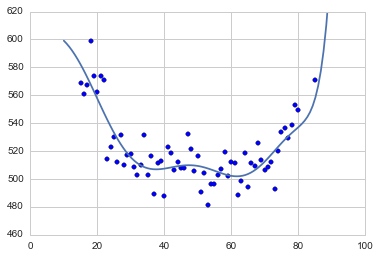

In [22]:
model = Pipeline([('poly', PolynomialFeatures(degree=10)),
                  ('linear', LinearRegression())])
model.fit(reshaped_sleep_values, sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
fn = lambda x: model.predict(x)[0]

print('Variance Score: %.2f' % model.score(reshaped_sleep_values, sleep_by_age.mean_minutes.values))


plot_regression(fn)

Just as we suspected, the line looks almost perfectly fit except on the boundaries where it goes haywire. Also our variance score has only increased by 2 percentage points but we've increased the degree by 5. We're starting to see dimishing returns with the complexity of our model.